# Hitters: Baseball Player's Salary Prediction

*Author: Rabindra Nepal*

- Major League Baseball Data from the 1986 and 1987 seasons.
- Data variables represent players' batting performance from 1986 and their career records, in addition to their 1987 salary.
- Objective of the project: EDA and build a prediction model to predict a player's salary.


## Content:
 - EDA
 - Important variables analysis
 - Missing value imputation
 - Outlier analysis
 - Feature engineering
 - Categorical variables encoding and Numerical features scaling
 - Modelling: Linear Regression, k-NN model, LightGBM model
 - LightGBM: model interpretation with SHAP value
 - Illustratative Neural Network Model: MLP model
 - Bias-variance trade-off
 - Dimensionality Reduction

In [105]:
# libraries
import time
import os, csv, math
import random
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)  
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

# Sklearn - ML library
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold, GroupKFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# lgb/model interpretor and hyperparams tuner
import lightgbm as lgb
from lightgbm import LGBMRegressor
import shap
import optuna

# Tensorflow: Deep learning library
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import plot_model

# dimensionality reduction
from sklearn.decomposition import PCA
from umap import UMAP

In [106]:
# Importing dataset
df = pd.read_csv("Hitters.csv")

In [107]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N



## EDA

I this section we will cover following topics:
- Descriptive analysis of the data to explain how salary  is impacted by different variables.
- Missing value imputation
- Important features determination and selection
- Any additional features engineering

In [108]:
print(f"Number of records in the dataset: {df.shape[0]}")
print(f"Number of features in the dataset: {df.shape[1]}")

Number of records in the dataset: 322
Number of features in the dataset: 20


In [109]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,1)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = nan_df.append(complete_df, sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 template='plotly_dark',
                 opacity = 0.6,
                 color_discrete_sequence=['#dbdbdb','#38cae0'],
                 width=800,
                 height=400)
    fig.show()

plot_missingness(df)

In [110]:
df.Salary.isnull().sum()

59

***Observation from Missingness plot:***
- As seen above in the missingness chart, only Salary feature (which is also our target variable to predict) has some missing values.
- We can handle it three different ways:
    - Dropping the records with missing value - given the size of the data set, we don't want to drop in this case.
    - Using the records with salary missing as test set, however, we will not be able to evaulate the accuracy of prediction for it.
    - Imputation of the salaray based on other features: mean/medain impute, IterativeImpute based on other features, KNNImpute etc. We will follow this strategy in this case.

In [111]:
# information on all the features: data types, null value, memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

**Observation:** Three non-numerical/categorical variables, reset are numerical variables.

In [112]:
# more info on numerical variables
pd.set_option('display.precision', 0)
df.describe().T.style.background_gradient(cmap="Blues")

,count,mean,std,min,25%,50%,75%,max
AtBat,322,381,153,16,255,380,512,687
Hits,322,101,46,1,64,96,137,238
HmRun,322,11,9,0,4,8,16,40
Runs,322,51,26,0,30,48,69,130
RBI,322,48,26,0,28,44,65,121
Walks,322,39,22,0,22,35,53,105
Years,322,7,5,1,4,6,11,24
CAtBat,322,2649,2324,19,817,1928,3924,14053
CHits,322,718,654,4,209,508,1059,4256
CHmRun,322,69,86,0,14,38,90,548


In [113]:
pd.set_option('display.precision', 3)

#### Categorical and Numberical columns

In [114]:
numerical_features = []; categorical_features = []
for f in df.columns:
    if type(df[f].values[0]) == str:
        categorical_features.append(f)
    else:
        numerical_features.append(f)
print("Categorical variables: ", np.array(categorical_features))
print("Numerical variables: ", np.array(numerical_features))

Categorical variables:  ['League' 'Division' 'NewLeague']
Numerical variables:  ['AtBat' 'Hits' 'HmRun' 'Runs' 'RBI' 'Walks' 'Years' 'CAtBat' 'CHits'
 'CHmRun' 'CRuns' 'CRBI' 'CWalks' 'PutOuts' 'Assists' 'Errors' 'Salary']


In [115]:
# number of categories by each cat feature:
for f in categorical_features:
    print(f"{f} : unique categories: {df[f].unique()}")

League : unique categories: ['A' 'N']
Division : unique categories: ['E' 'W']
NewLeague : unique categories: ['A' 'N']


In [116]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


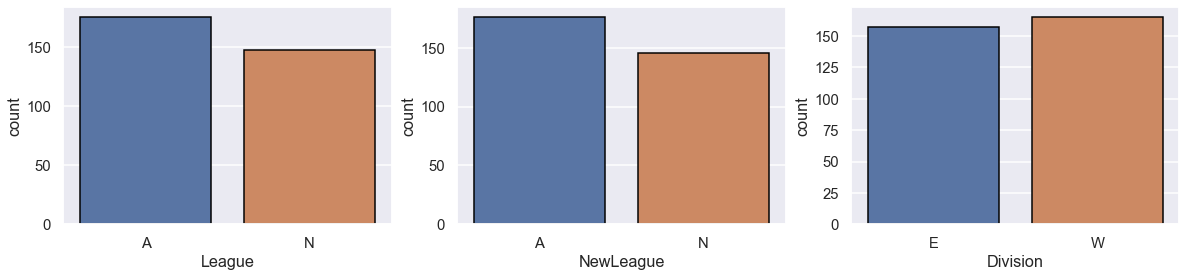

In [117]:
# distribution of cat variables
sns.set_theme("talk", font_scale=0.9)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
fig.set_facecolor("#fff")
for i, c in enumerate(['League', 'NewLeague', 'Division']):
    #axs[i].grid(color="lightgrey", alpha=0.7, axis="both", zorder=0)
    sns.countplot(x=c, data=df[categorical_features], ax=axs[i], edgecolor="#000");

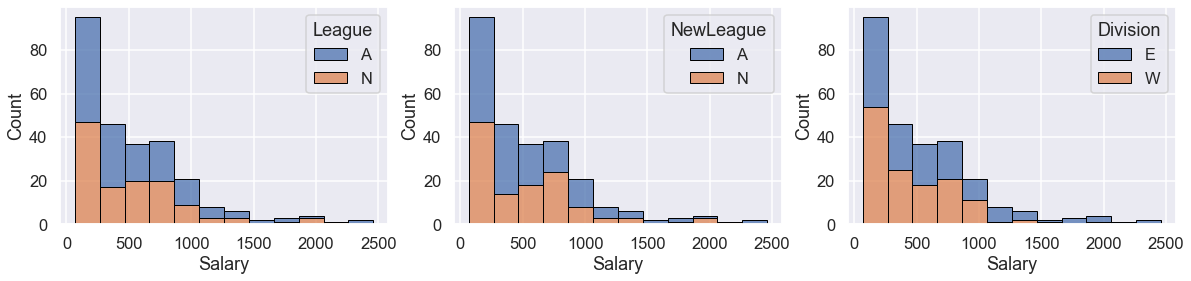

In [118]:
# distribution of salaray variable
sns.set_theme("talk", font_scale=1.0)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 4))
fig.set_facecolor("#fff")
for i, c in enumerate(['League', 'NewLeague', 'Division']):
    #axs[i].grid(color="lightgrey", alpha=0.7, axis="both", zorder=0)
    sns.histplot(x="Salary", hue=c, data=df, bins=12, multiple="stack", ax=axs[i], edgecolor="#000", linewidth=1);

#### Parellel-coordinates diagram for categorical variables:

- Illustrating the impact of all categorical variables on the 'Salary'

In [119]:
plt.figure(figsize=(12, 3));

fig = px.parallel_categories(data_frame=df[['League', 'NewLeague', 'Division', 'Salary']].dropna(), 
                       color="Salary", 
                       template="plotly_dark",
                       color_continuous_scale=["#dbdbdb", "#38cae0"],
                       title="Salary By Categorical Variables",
                       )
fig.update_layout(
                width=800,
                height=350,
                xaxis_title="Categorical Variable",
                yaxis_title="Variable Categories",
        )
fig.show()

<Figure size 864x216 with 0 Axes>

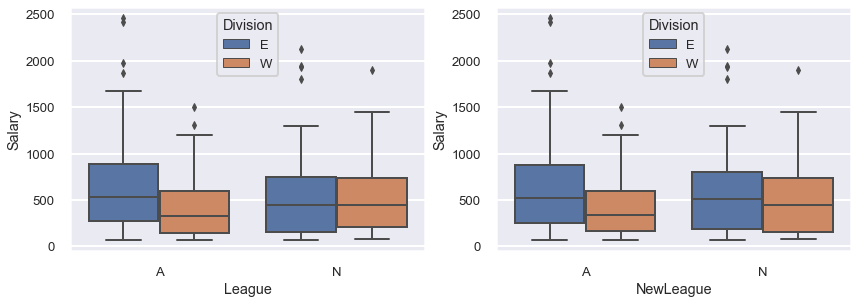

In [120]:
# the Salary across the division in 1986 and 1987 league seasons
sns.set_theme("poster", font_scale=0.6)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4.5))
for i, c in enumerate(['League', 'NewLeague']):
    sns.boxplot(x=c, y="Salary", hue="Division", data=df, ax=axs[i], linewidth=2);

***Observations:***
- Salaray distribution is skewed towards the left and most of the players have salaray < 500 (in $1000)
- There is not clear difference on salaray distribution based on League or NewLeague. However, more players from E Division have higher salaray in general. 

In [121]:
# Plotting the distribution of each feature:
def plot_numerical_features_distribution(df, num_features=numerical_features):
    sns.set_style("white")
    sns.set_theme('talk', font_scale=0.9)
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(28, 22))
    columns_ = num_features
    if 'Salary' in columns_:
        columns_.remove('Salary')
    k = 0
    for r in range(4):
        for c in range(4):
            feature = columns_[k]
            sns.histplot(x=columns_[k], data=df, bins=15, ax=axs[r, c], kde=True, edgecolor="#000", linewidth=1)
            k += 1
    plt.show()

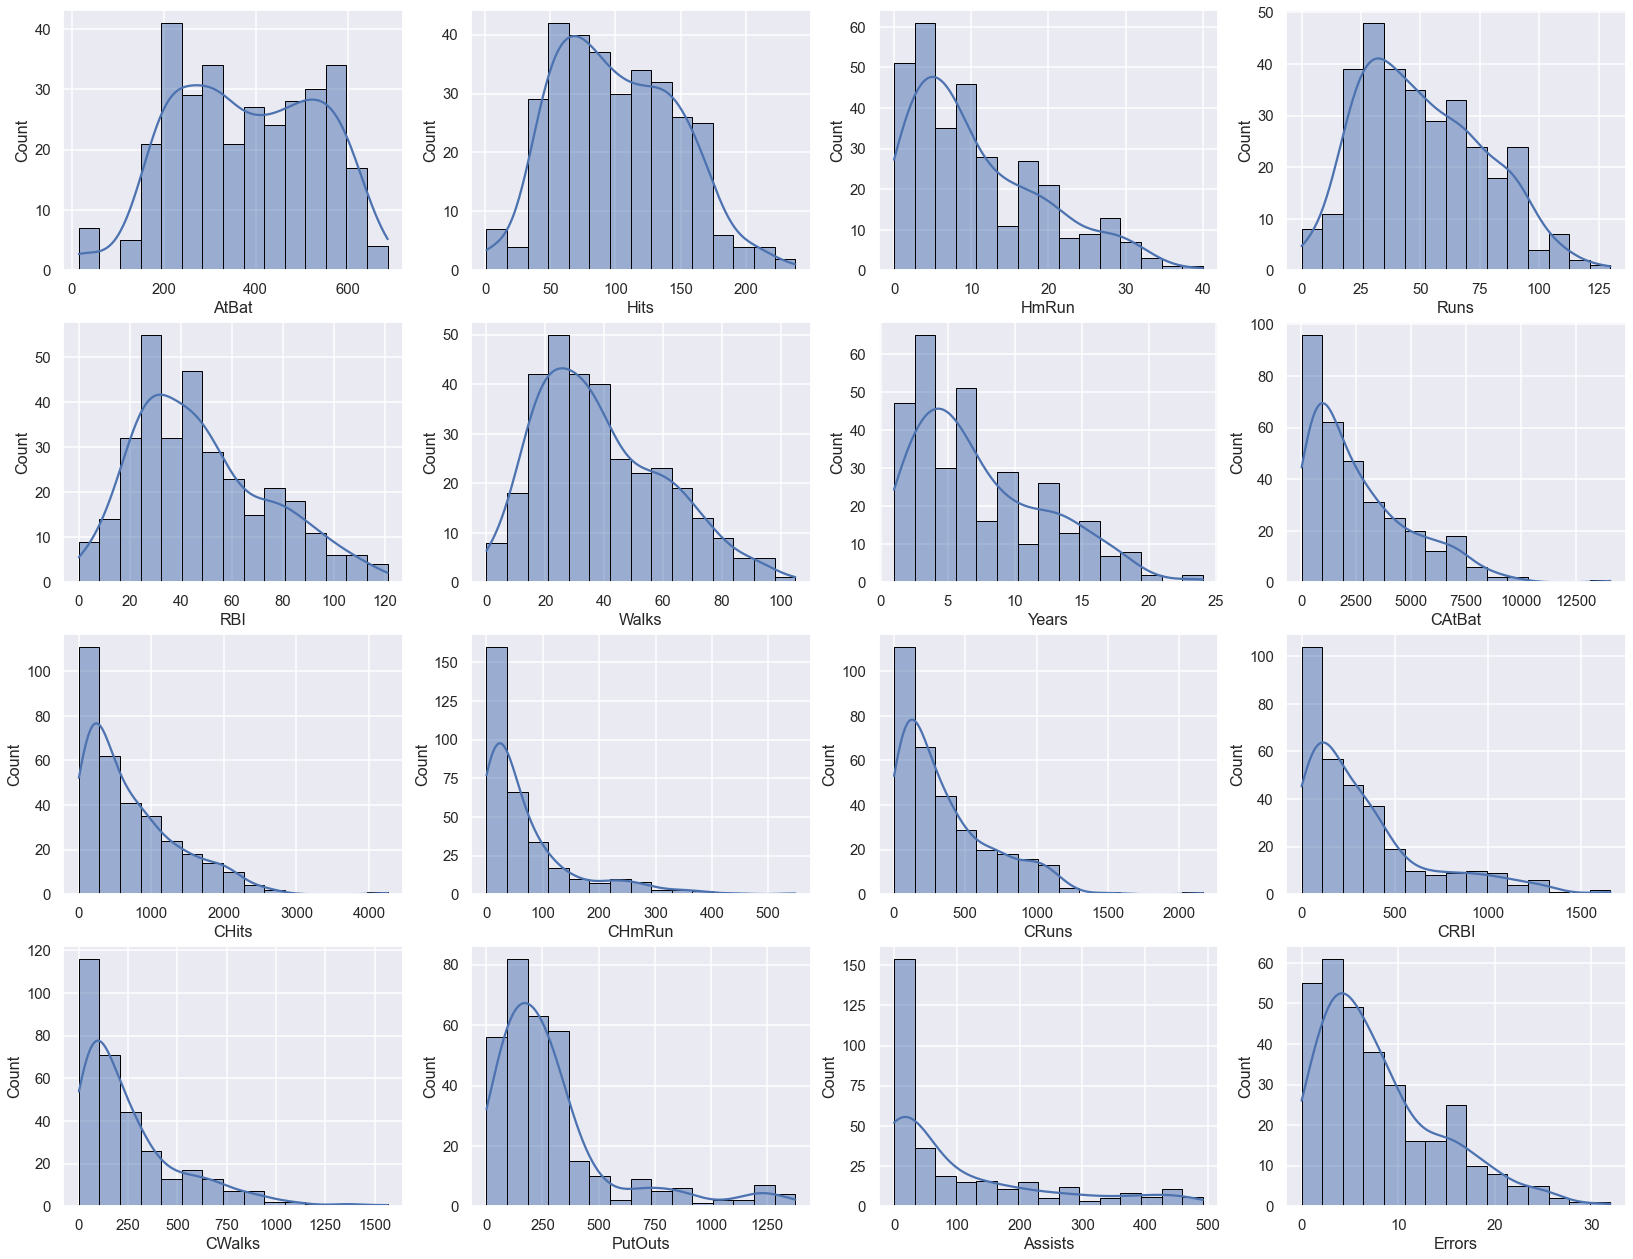

In [122]:
plot_numerical_features_distribution(df)

### Features Transformation

- Usually, normal distributions of features help to build a robust model with improved performance - especially for a algorithm like Linear Regression. However, it is not requirement for the most of the algorithms. **We will not be using it for now** - mainly for similicity in results interpretation.

- In this case, **Log-transformation** may be enough to transform those left-skewed distributions seen in the plot above.
- Since our target 'Salary'is also left-skewed, it makes sense to have similar transformation for the target too. It will require inverse transformation to interpret the results later in the same unit.

In [123]:
# left-skewed feature distribution:
transform_features = False

if transform_features:
    transform_list = ["HmRun", 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors']
    
    for feature in transform_list:
        df[feature] = df[feature].apply(lambda x: 0 if x == 0 else math.log10(x))

In [124]:
# Notice the distribution change of features above that are transformed
# plot_numerical_features_distribution(df)

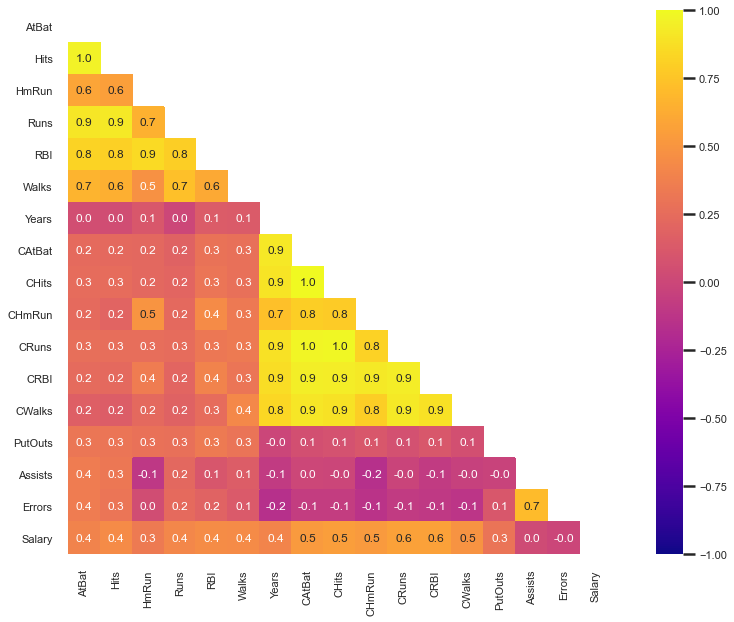

In [125]:
# Rearranging oolumns for presentation
tmp = df.copy()
salaries = df.Salary
del tmp['Salary']
tmp['Salary'] = salaries

# plotting
corr = tmp.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.set_theme('poster', font_scale=0.5)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 10))
    ax = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, square=True, cmap='plasma', annot=True, fmt='.1f')

#### Observation from Heatmap above:
- The highest correlated variables with Salary are: CRuns, CRBI, CWalks, CHmRun, etc.
- The least correlated variables with Salary are: Errors, Assists, PutOuts, HmRun etc.**

#### Categorical feature encoding

In [126]:
# Encoding categorical features as numerical feature:
# One hot encoding: doing it manually here as we have only two categories for each variables
# Can also apply: LabelEncoder

df["League_A"] = df.League.apply(lambda x: 1 if x == 'A' else 0)
df["Division_E"] = df.Division.apply(lambda x: 1 if x == 'E' else 0)
df["NewLeague_A"] = df.NewLeague.apply(lambda x: 1 if x == 'A' else 0)

for f in ['League', 'Division', 'NewLeague']:
    if f in df.columns:
        del df[f]

### Missing Value Imputation

**1.  Drop missing value records**\
**2.  Impute the missing values:**
- Imputation of Salary can be done in different ways:
    - Simple imputation: replacing missing values with mean or median salaray
    - Stratified sub-groups mean or median imputation: based on some other features, such as League or Division, we can impute the missing salary from the mean or median of such sub-groups.
    - *In this case*, we will impute missing salary with *KNNImputer*, where missing Salary will be imputed based on neighbors' feature values
    - Other option may be IterativeImputer - impute based on the other multiple features.

In [127]:
# Scaling the features before the KNNImpute
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns)


imputer = KNNImputer(n_neighbors=5, weights='distance')
df_scaled_imputed = imputer.fit_transform(df_scaled.values)

# reverting back to the original form of data
df = pd.DataFrame(scaler.inverse_transform(df_scaled_imputed), columns=df.columns)

In [128]:
df.Salary.isnull().sum()  # No missing value in the Salary anymore

0

### Impact of important features on Salary

- Scatter plots of some important features with Salary
- Categorize some of the important variables that are numeric into bins and further analyze their impact on Salary.

In [129]:
# Select a few important numerical features and categorizing each into 5 bins

binning_features = ['CRuns', 'CRBI', 'CWalks', 'CHmRun']

for f in binning_features:
    binned_feature_name = f"{f}_bin"
    
    bin_name_map = {0: "low", 1: "medium", 2: "high"}
    binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')  # categorize into 5 different bins
    # adding new feature into dataframe
    df[binned_feature_name] = binner.fit_transform(df[f].values.reshape(df.shape[0], 1)).flatten()
    df[binned_feature_name] = df[binned_feature_name].map(bin_name_map)

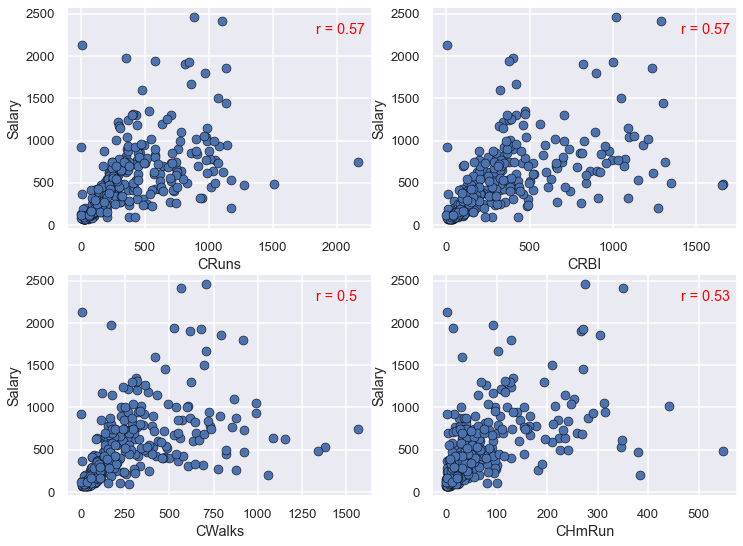

In [135]:
# Plotting a few important features with Salary
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 9))
k = 0
for i in range(2):
    for j in range(2):
        sns.set_style("white")
        sns.set_theme("talk", font_scale=0.8)
        feature = binning_features[k]
        sns.scatterplot(x=feature, y='Salary', data=df, ax=axs[i, j], edgecolor="#000", linewidth=0.5);
        corr, _ = np.round(pearsonr(df.Salary.values, df[feature].values), 2)
        axs[i, j].text(max(df[feature])*0.85, max(df.Salary)*0.92, f"r = {corr}", c="red");
        k += 1

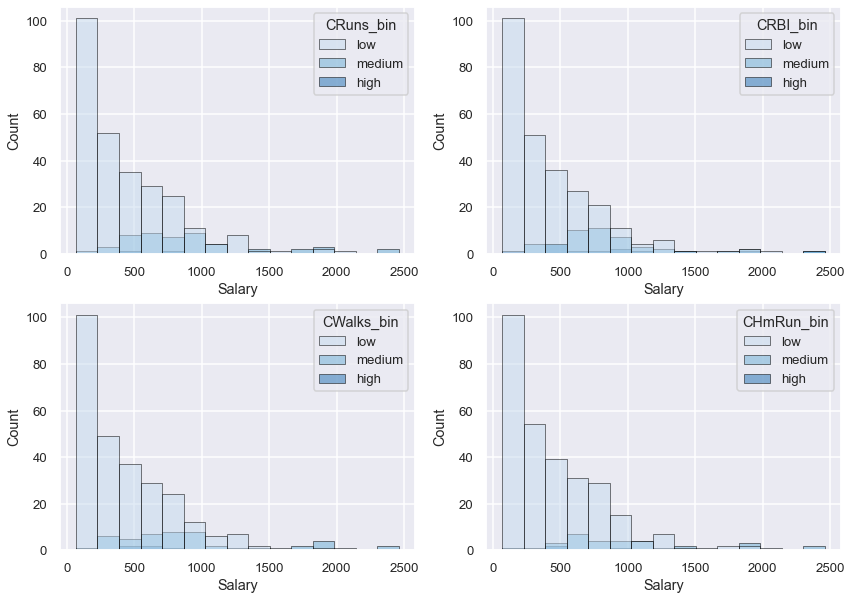

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
binned_feature_names = [i for i in df.columns if "_bin" in i]
k = 0
for i in range(2):
    for j in range(2):
        #sns.set_style("white")
        feature = binned_feature_names[k]
        sns.histplot(x="Salary", hue=feature, data=df, bins=15, ax=axs[i, j], palette='Blues', edgecolor="#000", linewidth=0.5);
        k += 1

### Outlier Analysis

In [29]:
# Outlier analysis:
# Interquartile range:

def univaraiate_outlier_analysis(df, l=0.25, u=0.75):
    
    numerical_features = []
    for f in df.columns:
        if type(df[f].values[0]) != str:
            numerical_features.append(f)
            
    for f in numerical_features:
        q1 = df[f].quantile(l)
        q3 = df[f].quantile(u)
        iqr = q3 - q1           # inter-quantile range
        
        outliers = df[(df[f] < q1 - 1.5*iqr) | (df[f] > q3 + 1.5*iqr)]
        if outliers.shape[0] > 0:
            print(f"{f} has {outliers.shape[0]} outliers in the data.")
        else:
            print(f"{f} has no outliers in the data.")

In [30]:
# Potential outliers based on individual features
# Within the following wide inter-quantile range, we don't have any outliers
univaraiate_outlier_analysis(df, l=0.05, u=0.95)

AtBat has no outliers in the data.
Hits has no outliers in the data.
HmRun has no outliers in the data.
Runs has no outliers in the data.
RBI has no outliers in the data.
Walks has no outliers in the data.
Years has no outliers in the data.
CAtBat has no outliers in the data.
CHits has no outliers in the data.
CHmRun has no outliers in the data.
CRuns has no outliers in the data.
CRBI has no outliers in the data.
CWalks has no outliers in the data.
PutOuts has no outliers in the data.
Assists has no outliers in the data.
Errors has no outliers in the data.
Salary has no outliers in the data.
League_A has no outliers in the data.
Division_E has no outliers in the data.
NewLeague_A has no outliers in the data.


***Observations:***

  - There are a few outliers based on the features CHits, CHmRun and CWalks. If we reduce the inter-quartile range for above analysis into the conventional 25%, 75% endpoints, we will have more outliers.
  - We will not be dropping these potential outliers - these are likely true outliers and we will aim to build a model that captures non-linear behavior than a simple linear normal relationship in the data.
  - Outlier removal **depends** upon the purpose of a model: if we are building a model to predict the most of the normal records in a population, it is a good idea to drop outliers and build a robust model that works for most of the predictions without keeping expectation that model will work for extreme cases. However, there might be cases where we want  to use a model to make predictions for non-regular cases.
  - As we want to understand the data as better as possible, let us keep these outliers and see how to they affect as we build different models.

In [31]:
# from sklearn.neighbors import LocalOutlierFactor
# clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)   # Another method to check outliers in the data

### Feature Engineering

- Above, we introduced a few features by binning some important features: CRuns, CRBI, CWalks, CHmRun
- Let us engineer some more features that might have meaningful correlation with the Salary

In [32]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_A,Division_E,NewLeague_A,CRuns_bin,CRBI_bin,CWalks_bin,CHmRun_bin
0,293.0,66.0,1.0,30.0,29.0,14.0,1.0,293.0,66.0,1.0,30.0,29.0,14.0,446.0,33.0,20.0,118.417,1.0,1.0,1.0,low,low,low,low
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,475.000,0.0,0.0,0.0,low,low,low,low
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,480.000,1.0,0.0,1.0,low,low,low,low
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,500.000,0.0,1.0,0.0,medium,medium,low,medium
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,91.500,0.0,1.0,0.0,low,low,low,low


#### New Features:

In [33]:
# Creating some new features from existing ones
df["Hits_Success"] = df["AtBat"] - df["Hits"]  # success --> times at bat - number of hits
# run conversion rate
df["last_Hits_rate"] = df["Hits"]/df["AtBat"]
df["last_AtBat_HmRun_rate"] = np.where(df["HmRun"] != 0, df["AtBat"]/df["HmRun"], 0)  # last year At Bat Home Run ratio
df['total_PutOuts'] = df['PutOuts'] * df['Years']
df["RBI_Walks_ratio"] = np.where(df["Walks"] != 0, df["RBI"]/df["Walks"], 0)


# Rate of score per year based on their career length
df["CAtBat_rate"] = df["CAtBat"]/df["Years"]
df["CHits_rate"] = df["CHits"]/df["Years"]
df["CHmRun_rate"] = df["CHmRun"]/df["Years"]
df["CRuns_rate"] = df["CRuns"]/df["Years"]
df["CRBI_rate"] = df["CRBI"]/df["Years"]
df["CWalks_rate"] = df["CWalks"]/df["Years"]
df["Hits_AtBat_rate"] = df["CHits"]/df["CAtBat"]
df["CAtBat_CHmRun_ratio"] = np.where(df["CHmRun"] != 0, df["CAtBat"]/df["CHmRun"], 0)   # At Bat Home run ratio

# Last year scores compared with their career score rates
df["last_AtBat_normalized"] =  np.where(df["CAtBat_rate"] !=0, df["AtBat"] / df["CAtBat_rate"], 0 )
df["last_Hits_normalized"] = np.where(df["CHits_rate"] !=0, df["Hits"] / df["CHits_rate"], 0 ) 
df["last_HmRun_normalized"] = np.where(df["CHmRun_rate"] !=0, df["HmRun"] / df["CHmRun_rate"], 0 ) 
df["last_CRun_normalized"] = np.where(df["CRuns_rate"] !=0, df["Runs"] / df["CRuns_rate"], 0 )  
df["last_RBI_normalized"] = np.where(df["CRBI_rate"] !=0, df["RBI"] / df["CRBI_rate"], 0 )  
df["last_Walks_normalized"] = np.where(df["CWalks_rate"] !=0, df["Walks"] / df["CWalks_rate"], 0 )  

# total number of bases of the player
df["Total_Bases"] = (df["CHits"] * 2) + (4 * df["CHmRun"])
df["Slugging_percent"] = df["Total_Bases"] / df["CAtBat"]

- In baseball statistics, total bases refers to the number of bases a player has gained with hits, i.e. the sum of his/her hits weighted by 1 for a single,
2 for a double, 3 for a triple and 4 for a home run.
- TOTAL_BASES = (1*single + 2 * double + 3 * triple + 4 * home_runs) = 2 (with avearge run) * nHits + 4 * CHmRun


In [34]:
# Features based on the last Transfer season at the end of 1986
# League (A/N) --> NewLeague (A/N)

def transfer_status(row):
    prev = row["League_A"]
    now = row["NewLeague_A"]
    
    if prev == now:
        return 'same'
    if prev == 1 and now == 0:
        return 'A_to_N'
    else:
        return 'N_to_A'
    
df["last_transfer"] = df.apply(lambda row: transfer_status(row), axis=1) 

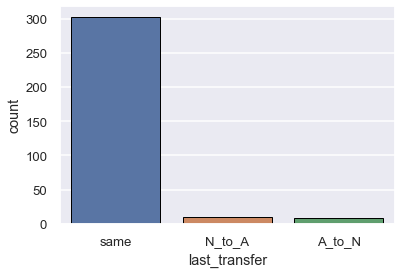

In [35]:
sns.countplot(x="last_transfer", data=df, edgecolor="#000", linewidth=1);

### Categorical features encoding

- One-Hot-Code type feature encoding

In [36]:
# encoding the binned features

cat_features_to_encode = []   # for encoding
num_features = []             # to standardize
for c in df.columns:
    if "_bin" in c:
        cat_features_to_encode.append(c)
    
    elif type(df[c].values[0]) == str:
        cat_features_to_encode.append(c)
        
    else:
        if c != 'Salary':
            num_features.append(c)

In [37]:
# One-Hot-Encoding last_tranfer feature into the dataframe

transfer_dummies = pd.get_dummies(df[cat_features_to_encode], prefix=None)
df = pd.concat([df, transfer_dummies], axis=1)

In [38]:
# removing the cat features included above as one-hot-encoding
for c in cat_features_to_encode:
    del df[c]

In [39]:
df.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_A,Division_E,NewLeague_A,Hits_Success,last_Hits_rate,last_AtBat_HmRun_rate,total_PutOuts,RBI_Walks_ratio,CAtBat_rate,CHits_rate,CHmRun_rate,CRuns_rate,CRBI_rate,CWalks_rate,Hits_AtBat_rate,CAtBat_CHmRun_ratio,last_AtBat_normalized,last_Hits_normalized,last_HmRun_normalized,last_CRun_normalized,last_RBI_normalized,last_Walks_normalized,Total_Bases,Slugging_percent,CRuns_bin_high,CRuns_bin_low,CRuns_bin_medium,CRBI_bin_high,CRBI_bin_low,CRBI_bin_medium,CWalks_bin_high,CWalks_bin_low,CWalks_bin_medium,CHmRun_bin_high,CHmRun_bin_low,CHmRun_bin_medium,last_transfer_A_to_N,last_transfer_N_to_A,last_transfer_same
count,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000,322.000
mean,380.929,101.025,10.770,50.910,48.028,38.742,7.444,2648.683,717.571,69.491,358.795,330.118,260.239,288.938,106.913,8.040,508.674,0.543,0.488,0.547,279.904,0.260,60.000,2144.425,1.410,323.486,86.412,8.178,43.435,38.811,30.853,0.261,76.565,1.281,1.285,1.437,1.290,1.361,1.359,1713.106,0.621,0.006,0.839,0.155,0.040,0.817,0.143,0.019,0.839,0.143,0.012,0.891,0.096,0.028,0.031,0.941
std,153.405,46.455,8.709,26.024,26.167,21.639,4.926,2324.206,654.473,86.266,334.106,333.220,267.058,280.705,136.855,6.368,425.793,0.499,0.501,0.499,109.066,0.036,76.489,2927.569,0.800,133.467,39.522,6.633,21.280,21.051,17.107,0.026,119.713,0.511,0.556,0.816,0.569,0.623,0.579,1593.738,0.084,0.079,0.369,0.363,0.197,0.387,0.350,0.135,0.369,0.350,0.111,0.312,0.295,0.165,0.174,0.236
min,16.000,1.000,0.000,0.000,0.000,0.000,1.000,19.000,4.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,67.500,0.000,0.000,0.000,12.000,0.050,0.000,0.000,0.000,10.250,2.000,0.000,0.500,0.000,0.000,0.143,0.000,0.287,0.222,0.000,0.000,0.000,0.000,8.000,0.286,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,255.250,64.000,4.000,30.250,28.000,22.000,4.000,816.750,209.000,14.000,100.250,88.750,67.250,109.250,7.000,3.000,181.217,0.000,0.000,0.000,187.000,0.240,23.032,546.750,0.861,218.000,55.104,2.938,26.031,22.291,18.314,0.248,26.978,0.979,0.962,0.919,0.918,0.998,1.000,489.000,0.565,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
50%,379.500,96.000,8.000,48.000,44.000,35.000,6.000,1928.000,508.000,37.500,247.000,220.500,170.500,212.000,39.500,6.000,400.000,1.000,0.000,1.000,278.000,0.259,34.806,1145.500,1.264,332.875,86.167,6.045,43.029,36.181,27.467,0.263,45.141,1.180,1.155,1.305,1.204,1.238,1.286,1232.000,0.625,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
75%,512.000,137.000,16.000,69.000,64.750,53.000,11.000,3924.250,1059.250,90.000,526.250,426.250,339.250,325.000,166.000,11.000,724.822,1.000,1.000,1.000,375.250,0.278,65.142,2458.000,1.746,429.981,116.497,12.094,58.729,54.812,40.597,0.278,76.585,1.486,1.503,1.878,1.597,1.650,1.666,2437.500,0.679,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000
max,687.000,238.000,40.000,130.000,121.000,105.000,24.000,14053.000,4256.000,548.000,2165.000,1659.000,1566.000,1378.000,492.000,32.000,2460.000,1.000,1.000,1.000,474.000,0.455,578.000,20880.000,7.333,642.667,195.667,30.000,107.750,101.500,88.500,0.352,1236.000,4.364,4.390,4.174,4.024,4.844,5.000,9152.000,0.830,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000


In [40]:
#sns.histplot(x="last_Walks_normalized", data=df[df.last_Walks_normalized > -0.02], bins=20);

### Scaling numerical features:
- Standardizing the numerical features using StandardScaler
- Standardized variable: $z = \frac{x - \mu}{\sigma}$

In [41]:
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

In [42]:
df.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'Salary', 'League_A', 'Division_E', 'NewLeague_A',
       'Hits_Success', 'last_Hits_rate', 'last_AtBat_HmRun_rate',
       'total_PutOuts', 'RBI_Walks_ratio', 'CAtBat_rate', 'CHits_rate',
       'CHmRun_rate', 'CRuns_rate', 'CRBI_rate', 'CWalks_rate',
       'Hits_AtBat_rate', 'CAtBat_CHmRun_ratio', 'last_AtBat_normalized',
       'last_Hits_normalized', 'last_HmRun_normalized', 'last_CRun_normalized',
       'last_RBI_normalized', 'last_Walks_normalized', 'Total_Bases',
       'Slugging_percent', 'CRuns_bin_high', 'CRuns_bin_low',
       'CRuns_bin_medium', 'CRBI_bin_high', 'CRBI_bin_low', 'CRBI_bin_medium',
       'CWalks_bin_high', 'CWalks_bin_low', 'CWalks_bin_medium',
       'CHmRun_bin_high', 'CHmRun_bin_low', 'CHmRun_bin_medium',
       'last_transfer_A_to_N', 'last_transfer_N_to_A', 'last_transfer_same'],
      

In [43]:
# If we carried features transformation above:
# If left skewed features are transformed, we can also transform Salary with Log10 transformation
# We need transform Salary back into given unit (v * $1000) for result analysis later

In [44]:
if transform_features:
    df.Salary = df.Salary.apply(lambda x: math.log10(x))
    y = df.Salary
    X = df.drop(columns=["Salary"])
else:
    y = df.Salary
    X = df.drop(columns=["Salary"])

# Prediction Modeling


In this section we will cover following topics:

- Approach to get training and testing dataset
- Fitting a linear (Linear Regression), non-linear (K-NN) and tree-based model (LightGBM)
- Evaluate the performance of each model
- Bias vs variance relationships for each model
- Illustrative deep learning model with advantages and disadvantages of deep learning with this dataset.

## Linear Regression

**Feature Selection**

- Linear Regression assumes no multicolinearity among the features. As we saw above from the heatmap that there are strong correlation between some of the features. Therefore, we may need to drop some of the features. We will select the features for linear regression model through: recursive feature elimination method. In this method, features are recursively removed one a time (custom) and inclusion of that particular feature is decided by the impact on the model performance.

In [45]:
# Feature selection through RFE

n_features = []
cv_rmse_list = []
for n in range(X.shape[1]-2, 2, -1):
    regressor = LinearRegression()
    selector = RFE(estimator=regressor, n_features_to_select=n, step=1, verbose=0)
    selector.fit(X, y)
    select_features = list(X.columns[selector.support_])
    
    cv_score = cross_val_score(estimator=regressor, X=X[select_features], y=y, cv=5, scoring="neg_mean_squared_error")
    rmse_score = np.sqrt(-cv_score).mean()
    n_features.append(n)
    cv_rmse_list.append(rmse_score)
    #print(f"n: {n}, CV-RMSE: {rmse_score}")

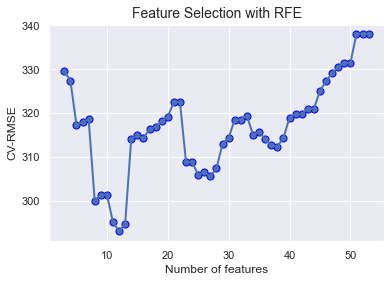

In [46]:
sns.set_theme("notebook")
plt.figure(figsize=(6, 4))
plt.plot(n_features, cv_rmse_list, linewidth=2);
plt.scatter(n_features, cv_rmse_list, s=50, edgecolors="blue")
plt.xlabel("Number of features", fontsize=12)
plt.ylabel("CV-RMSE", fontsize=12);
plt.title("Feature Selection with RFE", fontsize=14);

In [47]:
# Feature selection through RFE
regressor = LinearRegression()
selector = RFE(estimator=regressor, n_features_to_select=13, step=1, verbose=0)
selector.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=13)

In [48]:
# features: to include or not
selector.support_

array([False,  True, False, False, False, False,  True, False, False,
        True,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False,  True,  True,
       False,  True, False, False,  True,  True,  True, False, False,
       False])

In [49]:
# ranking the features
selector.ranking_

array([12,  1, 26, 35, 27,  6,  1, 17,  9,  1,  1, 23,  7, 33, 22, 43, 25,
       37, 40,  1,  2, 34, 11, 38, 19,  5, 42,  4, 20, 16, 13, 24, 18, 21,
       29, 39, 28, 15, 10, 36,  1,  1,  3,  1,  1, 30,  1, 41,  8,  1,  1,
        1, 31, 32, 14])

In [50]:
# Selected top 30 features
select_features = list(X.columns[selector.support_])
np.array(select_features)

array(['Hits', 'Years', 'CHmRun', 'CRuns', 'Hits_Success',
       'CRuns_bin_high', 'CRuns_bin_low', 'CRBI_bin_high', 'CRBI_bin_low',
       'CWalks_bin_high', 'CHmRun_bin_high', 'CHmRun_bin_low',
       'CHmRun_bin_medium'], dtype='<U17')

In [51]:
NFOLDS = 5

def lr_cv_trainer(X, y, params={}, cv=5, verbose=0):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=10)  # 5-folds cross-validation training
    
    # collect validation set prediction
    predictions = np.zeros(len(y))  # to store validation prediction results
    avg_validation_rmse = 0; fold = 1
    for train_idx, val_idx in kfolds.split(X):
        
        if verbose > 0:
            print("="*35)
            print("FOLD: ", fold)
            print("="*35)

        X_train, X_valid = X.values[train_idx], X.values[val_idx]
        y_train, y_valid = y.values[train_idx], y.values[val_idx]
        
        model = LinearRegression(**params)
        # model fitting
        model.fit(X_train, y_train)

        train_rmse = math.sqrt(metrics.mean_squared_error(y_train, model.predict(X_train)))
        valid_rmse = math.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid)))

        if verbose > 0:
            print(f"Training RMSE: {round(train_rmse, 3)}")
            print(f"Validation RMSE: {round(valid_rmse, 3)}")
            
        predictions[val_idx] = model.predict(X_valid)
        avg_validation_rmse += valid_rmse/cv
        fold += 1
        
    del model
    print("")
    print("="*35)
    print("DONE! Average CV RMSE: ", round(avg_validation_rmse, 3))
    print("="*35)
    return predictions

In [52]:
_ = lr_cv_trainer(X, y, params={}, cv=NFOLDS, verbose=1)

FOLD:  1
Training RMSE: 232.667
Validation RMSE: 290.723
FOLD:  2
Training RMSE: 235.67
Validation RMSE: 308.914
FOLD:  3
Training RMSE: 243.858
Validation RMSE: 255.824
FOLD:  4
Training RMSE: 216.803
Validation RMSE: 388.686
FOLD:  5
Training RMSE: 228.118
Validation RMSE: 394.311

DONE! Average CV RMSE:  327.692


In [53]:
# No feature selection
_ = lr_cv_trainer(X, y, params={}, cv=NFOLDS, verbose=0)


DONE! Average CV RMSE:  327.692


In [54]:
# Hyperparameters tuning: GridSearch: gridy algo

lr_params = {
            'fit_intercept': [True, False],
            'positive':      [True, False],
            }

# grid search of parameters
lr_grid_search = GridSearchCV(estimator=LinearRegression(), param_grid=lr_params, cv=NFOLDS, scoring="neg_mean_squared_error")
lr_grid_search.fit(X[select_features], y)

print("Best parameters:")
print(lr_grid_search.best_params_)

Best parameters:
{'fit_intercept': True, 'positive': False}


In [55]:
# training the best model
preds = lr_cv_trainer(X[select_features], y, params=lr_grid_search.best_params_, cv=NFOLDS, verbose=1)

FOLD:  1
Training RMSE: 280.458
Validation RMSE: 293.383
FOLD:  2
Training RMSE: 279.083
Validation RMSE: 309.237
FOLD:  3
Training RMSE: 292.883
Validation RMSE: 228.957
FOLD:  4
Training RMSE: 257.676
Validation RMSE: 367.584
FOLD:  5
Training RMSE: 288.211
Validation RMSE: 254.13

DONE! Average CV RMSE:  290.658


In [56]:
print("R2-Score: ", metrics.r2_score(y, preds).round(3))
print("MAE: ", metrics.mean_absolute_error(y, preds).round(3))

R2-Score:  0.52
MAE:  202.219


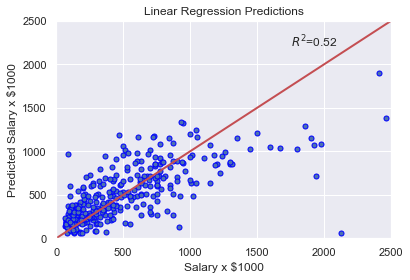

In [57]:
# plotting the predicted salaries with true values
plt.figure(figsize=(6, 4))
plt.scatter(y, preds, s=25, edgecolors="blue");
plt.plot([0, 2500], [0, 2500], c='r', linewidth=2)
plt.text(1750, 2200, f"$R^2$={metrics.r2_score(y, preds).round(3)}")
plt.xlim(0, 2500);
plt.ylim(0, 2500);
plt.xlabel("Salary x $1000")
plt.ylabel("Predicted Salary x $1000");
plt.title("Linear Regression Predictions");

### K-NN Model

- A simple non-linear model
- It predicts the result for unknown record comparing with the results of k neareset negihbors.
- We will work the selected features also for KNN model. We can use all the features in KNN model, however, we need to use a distance metric like *Mahalanobis distance* to find nearest neighbors in that case which accounts covariance among the features. 

In [136]:
def knn_cv_trainer(X, y, params={}, cv=5, verbose=0):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=0)  # 5-folds cross-validation training
    
    # collect validation set prediction
    predictions = np.zeros(len(y))  # to store validation prediction results
    avg_validation_rmse = 0; fold = 1
    for train_idx, val_idx in kfolds.split(X):
        
        X_train, X_valid = X.values[train_idx], X.values[val_idx]
        y_train, y_valid = y.values[train_idx], y.values[val_idx]
        
        model = KNeighborsRegressor(**params)
        # model fitting
        model.fit(X_train, y_train)

        train_rmse = math.sqrt(metrics.mean_squared_error(y_train, model.predict(X_train)))
        valid_rmse = math.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid)))

        if verbose > 0:
            # print(f"Training RMSE: {train_rmse}") 
            # no training accuracy in KNN, its lazy prediction model, it scans through train set during each prediction
            print(f"FOLD: {fold}, Validation RMSE: {round(valid_rmse, 3)}")
            
        predictions[val_idx] = model.predict(X_valid)
        avg_validation_rmse += valid_rmse/cv
        fold += 1
        
        del model
        
    print("")
    print("="*40)
    print("DONE! Average CV RMSE: ", round(avg_validation_rmse, 3))
    print("="*40)
    return predictions

In [137]:
_ = knn_cv_trainer(X[select_features], y, cv=5, verbose=1)   # cv-training the default model

FOLD: 1, Validation RMSE: 277.702
FOLD: 2, Validation RMSE: 255.009
FOLD: 3, Validation RMSE: 362.446
FOLD: 4, Validation RMSE: 217.695
FOLD: 5, Validation RMSE: 330.684

DONE! Average CV RMSE:  288.707


- **Notice an already better cross-validation RMSE score using KNN model than Linear Regression - even without parameters tuning.**
- This highlights the non-linearity the dataset.
- **Note** that we can introduce polynomial non-linearity in linear regression model by manually creating higher order features and using them in the training. However, it might not always be an efficient method as the degree of non-linearity is unknown and number of features increases exponentially with the polynomial order - might be a problem for small size data.
- We can also regularize Linear Regression model: using Lasso, Ridge or ElasticNet regression models.

In [60]:
# Best number of neighbors:

def plot_optimal_neighbors(X, y, select_features):
    
    neighbor_list = []
    rmse_list = []
    for k in range(1, 40):
        if k > 5:
            if k % 3 != 0: continue # skipping each 3rd k for k > 5     
        model = KNeighborsRegressor(n_neighbors=k, weights='distance', p=1)
        scores = cross_val_score(estimator=model, X=X[select_features], y=y, cv=5, scoring="neg_mean_squared_error")
        cv_rmse = np.sqrt(-scores).mean()
        
        neighbor_list.append(k)
        rmse_list.append(cv_rmse)
        
    # plotting
    sns.set_theme("notebook")
    plt.figure(figsize=(6, 4))
    plt.scatter(neighbor_list, rmse_list, s=50, edgecolors="blue")
    plt.plot(neighbor_list, rmse_list, c='blue', linestyle='--', linewidth=2.0)
    plt.xlabel("Number of neighbors (k)")
    plt.ylabel("CV-RMSE")
    plt.title("Optimal number of neighbors")
    plt.xlim(-1, 40)
    plt.ylim(250, 400)
    plt.show()

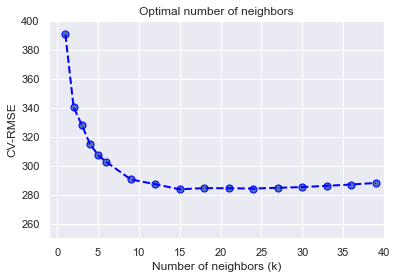

In [61]:
plot_optimal_neighbors(X, y, select_features)

In [62]:
# Hyperparameters tuning: GridSearch: gridy algo

knn_params = {
    'n_neighbors': [1, 5, 7, 9, 10, 11, 12, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3, 4, 5, 10],  # Order of Minkwoski distance
    }

# grid search of parameters
knn_grid_search = RandomizedSearchCV(estimator=KNeighborsRegressor(), param_distributions=knn_params, n_iter=80, cv=NFOLDS)
knn_grid_search.fit(X[select_features], y)

print("Best parameters:")
print(knn_grid_search.best_params_)

Best parameters:
{'weights': 'uniform', 'p': 1, 'n_neighbors': 10}


In [63]:
# Best model:

preds = knn_cv_trainer(X[select_features], y, params=knn_grid_search.best_params_, cv=5, verbose=1)

FOLD: 1, Validation RMSE: 263.939
FOLD: 2, Validation RMSE: 243.923
FOLD: 3, Validation RMSE: 351.168
FOLD: 4, Validation RMSE: 198.85
FOLD: 5, Validation RMSE: 322.823

DONE! Average CV RMSE:  276.14


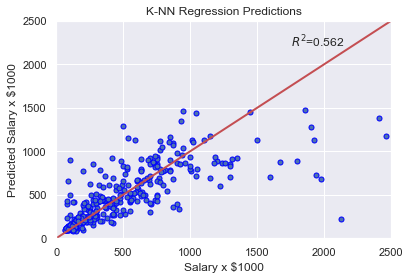

In [64]:
plt.figure(figsize=(6, 4))
plt.scatter(x=y, y=preds, s=25, edgecolors="blue");
plt.plot([0, 2500], [0, 2500], linewidth=2, c='r')
plt.xlim(0, 2500);
plt.ylim(0, 2500);
plt.text(1750, 2200, f"$R^2$={metrics.r2_score(y, preds).round(3)}")
plt.xlabel("Salary x $1000")
plt.ylabel("Predicted Salary x $1000");
plt.title("K-NN Regression Predictions");

In [65]:
print("R2-Score: ", metrics.r2_score(y, preds).round(3))
print("MAE: ", metrics.mean_absolute_error(y, preds).round(3))

R2-Score:  0.562
MAE:  165.635


### LightGBM Model

- LighGBM is an efficient implementation of GB-model, performance comparable to XGBoost or CatBoost but faster in general.

In [66]:
def lgb_cv_trainer(X, y, params={}, cv=5, verbose=0):
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=10)  # 5-folds cross-validation training
    
    # collect validation set prediction
    predictions = np.zeros(len(y))  # to store validation prediction results
    avg_validation_rmse = 0; fold = 1
    boosters = []
    for train_idx, val_idx in kfolds.split(X):
        
        if verbose > 0:
            print("="*40)
            print("FOLD: ", fold)
            print("="*40)

        X_train, X_valid = X.values[train_idx], X.values[val_idx]
        y_train, y_valid = y.values[train_idx], y.values[val_idx]
        
        model = LGBMRegressor(**params)
        # model fitting
        model.fit(X_train, y_train)

        train_rmse = math.sqrt(metrics.mean_squared_error(y_train, model.predict(X_train)))
        valid_rmse = math.sqrt(metrics.mean_squared_error(y_valid, model.predict(X_valid)))

        if verbose > 0:
            print(f"Training RMSE: {round(train_rmse, 3)}")
            print(f"Validation RMSE: {round(valid_rmse, 3)}")
            
        predictions[val_idx] = model.predict(X_valid)
        avg_validation_rmse += valid_rmse/cv
        fold += 1
        
        boosters.append(model)
        del model
        
    print("")
    print("="*40)
    print("DONE! Average CV RMSE: ", round(avg_validation_rmse, 3))
    print("="*40)
    return predictions, boosters

In [67]:
_, _ = lgb_cv_trainer(X, y, params={}, cv=NFOLDS, verbose=1)

FOLD:  1
Training RMSE: 108.562
Validation RMSE: 235.949
FOLD:  2
Training RMSE: 103.96
Validation RMSE: 259.137
FOLD:  3
Training RMSE: 105.489
Validation RMSE: 224.172
FOLD:  4
Training RMSE: 88.225
Validation RMSE: 318.232
FOLD:  5
Training RMSE: 109.689
Validation RMSE: 239.768

DONE! Average CV RMSE:  255.452


In [68]:
preds, _ = lgb_cv_trainer(X, y, params={}, cv=NFOLDS, verbose=1)   # No feature selection required for LightGBM --> does inherent feature selection through feature importance estimation

FOLD:  1
Training RMSE: 108.562
Validation RMSE: 235.949
FOLD:  2
Training RMSE: 103.96
Validation RMSE: 259.137
FOLD:  3
Training RMSE: 105.489
Validation RMSE: 224.172
FOLD:  4
Training RMSE: 88.225
Validation RMSE: 318.232
FOLD:  5
Training RMSE: 109.689
Validation RMSE: 239.768

DONE! Average CV RMSE:  255.452


In [69]:
# Equivalent mehtod using Sklearn
#np.mean(np.sqrt(-cross_val_score(LGBMRegressor(), X, y, cv=5, scoring="neg_mean_squared_error")))

**Hyperparameters tuning with Bayesian optimization technique:**
- We will use Optuna package to efficiently find out the best set of parameters for a XGBoost model

In [70]:
param_distributions = {
                        "n_estimators": optuna.distributions.IntUniformDistribution(20, 900),
                        "max_depth": optuna.distributions.IntUniformDistribution(1, 7),
                        "num_leaves": optuna.distributions.IntUniformDistribution(3, 133),
                        "learning_rate": optuna.distributions.LogUniformDistribution(1e-4, 0.2),
                        "reg_alpha": optuna.distributions.UniformDistribution(1e-2, 20),
                        "reg_lambda": optuna.distributions.UniformDistribution(1e-2, 20),
                        "colsample_bytree": optuna.distributions.UniformDistribution(0.2, 1.0),
                        }

tune_params = False
if tune_params:
    optuna_search = optuna.integration.OptunaSearchCV(LGBMRegressor(), param_distributions, max_iter=200,
                                                      scoring="neg_mean_squared_error")
    optuna_search.fit(X, y)

In [71]:
if tune_params:
    print(optuna_search.best_params_)

In [72]:
# free hyperparams tune usually overfits in the small dataset
# let us further tune params manually to avoid overfitting

lgb_params = {
                 'n_estimators': 600,
                 'max_depth': 2,
                 'num_leaves': 9,
                 'learning_rate': 0.014691891094913548,
                 'reg_alpha': 15.474736284590335,
                 'reg_lambda': 14.6480135050362,
                 'colsample_bytree': 0.44
             }

preds, boosters = lgb_cv_trainer(X, y, params=lgb_params, cv=NFOLDS, verbose=1)

FOLD:  1
Training RMSE: 190.144
Validation RMSE: 239.347
FOLD:  2
Training RMSE: 190.622
Validation RMSE: 240.085
FOLD:  3
Training RMSE: 198.377
Validation RMSE: 194.752
FOLD:  4
Training RMSE: 166.421
Validation RMSE: 325.392
FOLD:  5
Training RMSE: 192.191
Validation RMSE: 215.997

DONE! Average CV RMSE:  243.114


In [73]:
print("R2-Score: ", metrics.r2_score(y, preds).round(3))
print("MAE: ", metrics.mean_absolute_error(y, preds).round(3))

R2-Score:  0.662
MAE:  156.771


## (Overfitting) Model trained on a data without regularization and prediction on same data

- No cross-validation training
- Model trained and evaluated on same dataset - **just for insight and illustration.**

In [74]:
# prediction on the entire dataset
lgb_params["max_depth"] = 3
model = LGBMRegressor(**lgb_params)
model.fit(X, y)
predictions = model.predict(X)
print("RMSE (Prediction on full dataset): ", math.sqrt(metrics.mean_squared_error(y, predictions)))

RMSE (Prediction on full dataset):  159.13394783825825


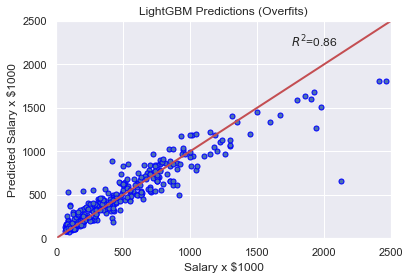

In [75]:
plt.figure(figsize=(6, 4))
plt.scatter(x=y, y=predictions, s=25, edgecolors="blue");
plt.plot([0, 2500], [0, 2500], linewidth=2, c='r')
plt.xlim(0, 2500);
plt.ylim(0, 2500);
plt.text(1750, 2200, f"$R^2$={metrics.r2_score(y, predictions).round(3)}")
plt.xlabel("Salary x $1000")
plt.ylabel("Predicted Salary x $1000");
plt.title("LightGBM Predictions (Overfits)");

### Following is the results from OOF predictions: 

- The model performance from the out-of-fold predictions during the cross-validation training can be trusted - **as long as** the training folds are created avoiding any information leakage across the folds.
- Overfitting can also be observed during the training progress - comparing performance on train set vs independent validation set.

- **Again,** we should also hold-out some data as a test set in order to correctly evaluate the model performance. In this case, we are only evaluating based on CV-OOF prediction as dataset is very small to separate for test set.

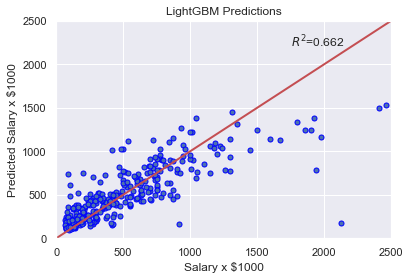

In [76]:
plt.figure(figsize=(6, 4))
plt.scatter(x=y, y=preds, s=25, edgecolors="blue");
plt.plot([0, 2500], [0, 2500], linewidth=2, c='r')
plt.xlim(0, 2500);
plt.ylim(0, 2500);
plt.text(1750, 2200, f"$R^2$={metrics.r2_score(y, preds).round(3)}")
plt.xlabel("Salary x $1000")
plt.ylabel("Predicted Salary x $1000");
plt.title("LightGBM Predictions");

In [77]:
print("R2-Score: ", metrics.r2_score(y, preds).round(3))
print("MAE: ", metrics.mean_absolute_error(y, preds).round(3))

R2-Score:  0.662
MAE:  156.771


### Feature importance in the LightGBM Model

In [78]:
# Weighted feature importance
def plot_feature_importance(boosters, plot_n_feature=X.shape[1]):
    features = list(X.columns)
    feature_gain = np.zeros(len(X.columns))
    
    for booster in boosters:
        feature_gain += booster.feature_importances_/NFOLDS

    tmp = pd.DataFrame(data={"feature": features, "gain": feature_gain})
    tmp = tmp.sort_values(by="gain", ascending=False)
    tmp.gain = tmp.gain/tmp.gain.sum()      # normalizing the features importance
    
    tmp = tmp[:plot_n_feature]  # plot only top features 

    plt.figure(figsize=(8, 10))
    sns.barplot(y="feature", x="gain", data=tmp);
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("Information Gain", fontsize=16)
    plt.ylabel("Feature", fontsize=16);
    plt.show()

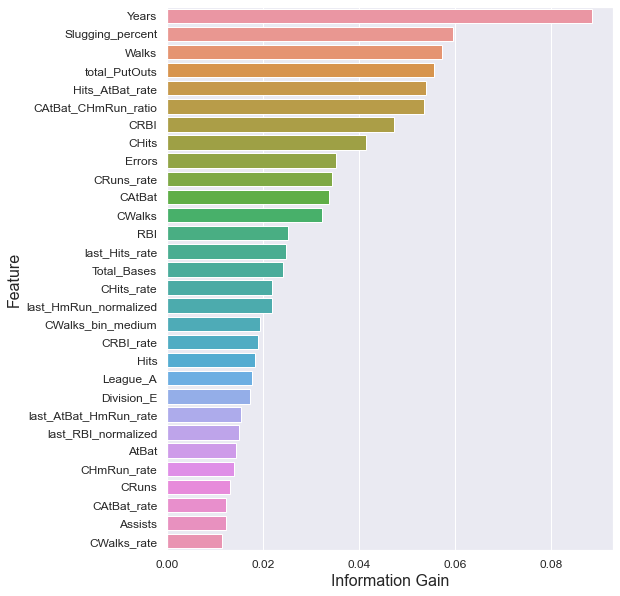

In [79]:
plot_feature_importance(boosters, plot_n_feature=30)

## Decision trees in the Model

- We can plot the individual decision tree in the boosted ensemble model and look into the details of how each trees contribute to the model prediction.

In [80]:
# Graphviz path
os.environ["PATH"] += os.pathsep + 'C:/Users/nepal/Anaconda3/Library/bin/graphviz/'

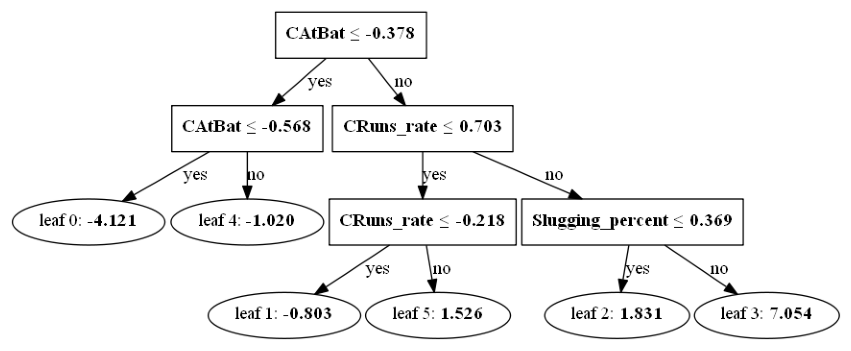

In [81]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_tree(model, ax=ax, tree_index=1, orientation="vertical");

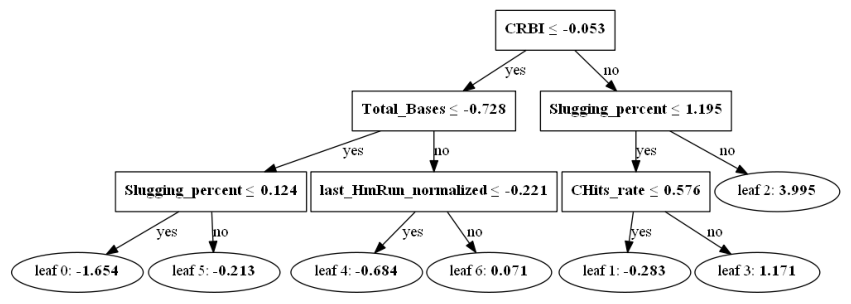

In [82]:
fig, ax = plt.subplots(figsize=(15, 25))
lgb.plot_tree(model, ax=ax, tree_index=100, orientation="vertical");

### Model Interpretaton with SHAP values 

- Decision tree based ensemble models are pretty interpretable, we can analyze model performance based on feature importance.
- SHAP value comes from game theory - Shapely value, which evaluates the contribution of each players given the outcome of a play. Same technique can be applied to evaluate the contribution of each feature based on the model performance.

In [83]:
# average shap values from boosters during 5-fold cross validation training
average_shap_values = np.zeros((X.shape))
for booster in boosters:
    explainer = shap.TreeExplainer(booster)
    average_shap_values += explainer.shap_values(X)/NFOLDS

In [84]:
# A separate LGB model
# regressor = LGBMRegressor().fit(X, y)
# explainer = shap.TreeExplainer(boosters[0])
# shap_values = explainer.shap_values(X)

In [85]:
shap_values = average_shap_values

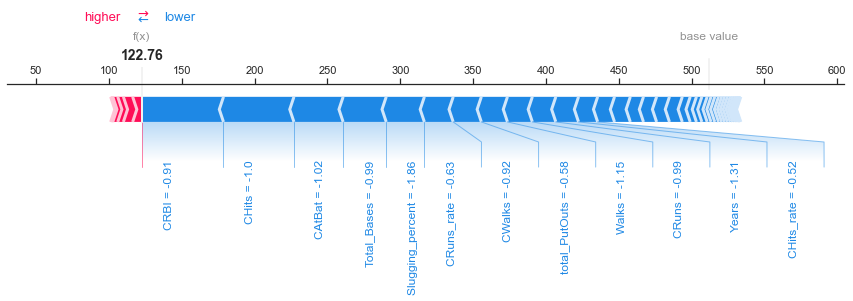

In [86]:
sns.set_style("white")
shap.force_plot(explainer.expected_value, shap_values[0], np.round(X.values[0], 2), feature_names=X.columns, 
                figsize=(15, 3), text_rotation=90, matplotlib=True, contribution_threshold=0.02)

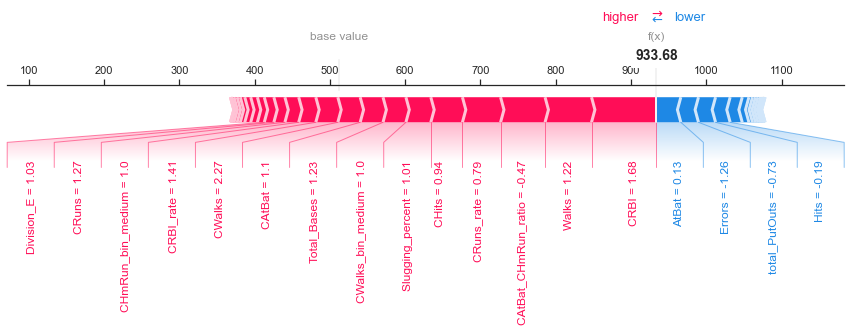

In [87]:
sns.set_style("white")
shap.force_plot(explainer.expected_value, shap_values[9], np.round(X.values[9], 2), feature_names=X.columns, 
                figsize=(15, 3.0), text_rotation=90, matplotlib=True, contribution_threshold=0.02)

In [88]:
y[0], y[9]  # true salaries for two samples above

(118.41678476828179, 1100.0)

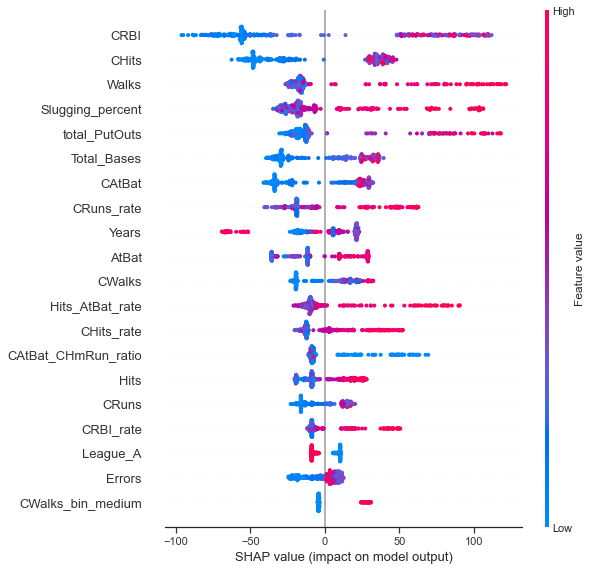

In [89]:
shap.summary_plot(shap_values, X)

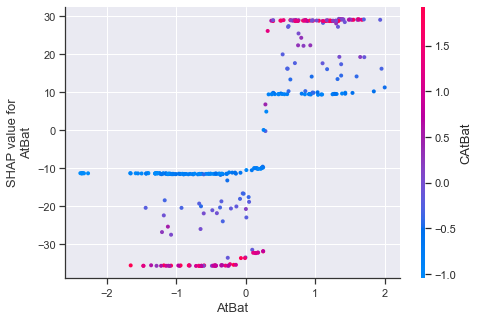

In [90]:
sns.set_theme("notebook")
shap.dependence_plot(0, shap_values, features=X)

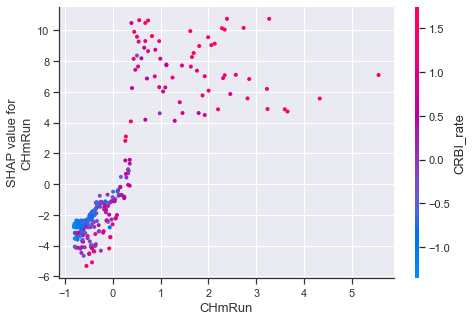

In [91]:
shap.dependence_plot(9, shap_values, features=X)

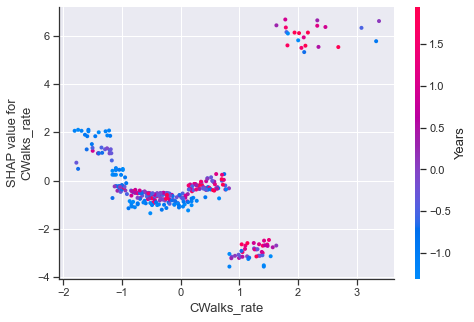

In [92]:
shap.dependence_plot(29, shap_values, features=X)

# Neural Network Model (For illustration)

- Will build a simple MLP (Multi-Layer Perceptron) model using Tensorflow
- Explore the shortcomings of training a NN model in a very small dataset.

In [93]:
# MLP Model
model = Sequential([
                    Dense(units=128, activation='relu', input_dim=X.shape[1], name="Input"),
                    Dense(32, activation='relu', name="HiddenLayer"),
                    Dropout(0.3),
                    Dense(1, name="Output"),
                ], name="Hitters",
            )
model.summary()

Model: "Hitters"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 128)               7168      
_________________________________________________________________
HiddenLayer (Dense)          (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
Output (Dense)               (None, 1)                 33        
Total params: 11,329
Trainable params: 11,329
Non-trainable params: 0
_________________________________________________________________


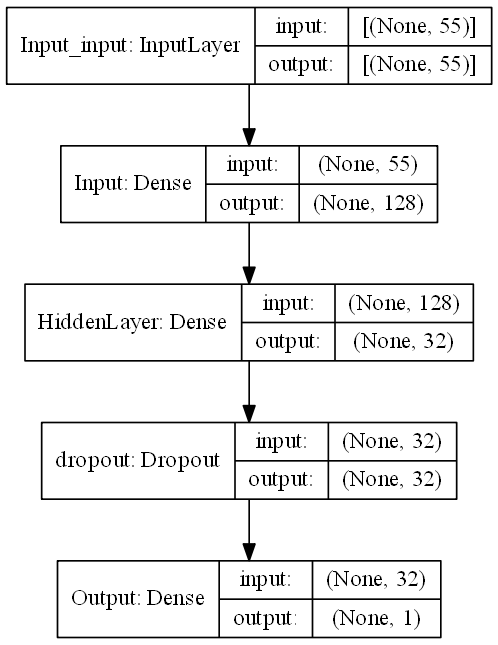

In [94]:
# plotting the MLP model architecture
plot_model(model, show_shapes=True, dpi=120)

In [95]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[RootMeanSquaredError()])

- Training the simple MLP model above
- Dataset will be divided into training and validation (20%) sets
- Loss (MSE) and RMSE metrics are recorded for both training and validation sets for each iteration of model training.

In [96]:
# training
model.fit(X, y, 
          validation_split=0.2, 
          epochs=50, 
          batch_size=16,  
          callbacks=[CSVLogger("results.csv")],
          verbose=1,
        );

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15/17 [=========================>....] - ETA: 0s - loss: 516419.0312 - root_mean_squared_error: 717.7663WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000192F0358288> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUT

Epoch 35/50
17/17 [==============================] - 0s 13ms/step - loss: 73357.9444 - root_mean_squared_error: 268.2183 - val_loss: 72008.9141 - val_root_mean_squared_error: 268.3448
Epoch 36/50
17/17 [==============================] - 0s 12ms/step - loss: 69516.3110 - root_mean_squared_error: 263.0302 - val_loss: 70693.0703 - val_root_mean_squared_error: 265.8817
Epoch 37/50
17/17 [==============================] - 0s 12ms/step - loss: 82598.0990 - root_mean_squared_error: 286.1358 - val_loss: 71543.7812 - val_root_mean_squared_error: 267.4767
Epoch 38/50
17/17 [==============================] - 0s 13ms/step - loss: 78126.6207 - root_mean_squared_error: 278.7999 - val_loss: 70623.0234 - val_root_mean_squared_error: 265.7499
Epoch 39/50
17/17 [==============================] - 0s 12ms/step - loss: 71779.4047 - root_mean_squared_error: 267.4647 - val_loss: 71358.7734 - val_root_mean_squared_error: 267.1306
Epoch 40/50
17/17 [==============================] - 0s 12ms/step - loss: 76933.

In [97]:
results = pd.read_csv("results.csv")
results[20:30]

,epoch,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error
20,20,78643.820,280.435,73794.719,271.652
21,21,87218.312,295.327,73837.109,271.730
22,22,79063.648,281.183,72351.992,268.983
23,23,88021.234,296.684,70999.633,266.458
24,24,84044.078,289.904,70685.117,265.867
25,25,92038.000,303.378,71014.969,266.486
26,26,83753.500,289.402,70842.695,266.163
27,27,81264.812,285.070,70422.867,265.373
28,28,87971.000,296.599,69815.797,264.227
29,29,81654.125,285.752,70624.336,265.752


In [98]:
min(results.val_root_mean_squared_error)

264.2267761230469

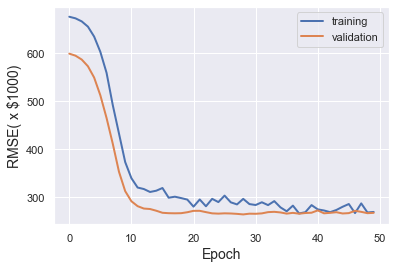

In [99]:
sns.set_theme("notebook")
plt.plot(results.epoch, results.root_mean_squared_error, label="training", linewidth=2);
plt.plot(results.epoch, results.val_root_mean_squared_error, label="validation", linewidth=2);
plt.ylabel("RMSE( x $1000)", fontsize=14);
plt.xlabel("Epoch", fontsize=14);
plt.legend();

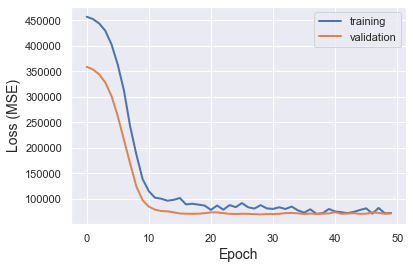

In [100]:
plt.plot(results.epoch, results.loss, label="training", linewidth=2);
plt.plot(results.epoch, results.val_loss, label="validation", linewidth=2);
plt.ylabel("Loss (MSE)", fontsize=14);
plt.xlabel("Epoch", fontsize=14);
plt.legend();

**Observation:**

- The best RMSE on validation set is ~ 260, which is roughly same as that of knn model, but worse than LGB model.
- From the plot above the model may be overfitted - as it is doing better on the randomly selected validation set than training set - validation set might not be the optimal one or it is too small for this dataset. Training never stabilizes becuase of a small training dataset.
- The dataset seems small for optimal training and it is not giving the best result compared tree-based model.
- **Practically**, we should not be working with a deep learning model for a tabular data - it has been proven by many research works and competition results that a tree based models like XGBoost, LightGBM or CatBoost outperform or at least perform as good as any complicated deep learning model. So it is not a good idea to overcomplicate the solution as long as much simpler and lighter models works that are easier to deploy.
- Deep learning models are usually preferred and produce much better solution for computer-vision and NLP problems.

## Dimensionality Reduction

- Project the full feature space into 2D and 3D plane
- Plotting in reduced dimension to see the isolation based on Salary values

### Principal Components Decomposition

In [101]:
decompose = PCA(n_components=2)
pca_comps = decompose.fit_transform(X)

In [102]:
decompose.explained_variance_ratio_.sum().round(3)  # total variance covered by 2 principle components

0.529

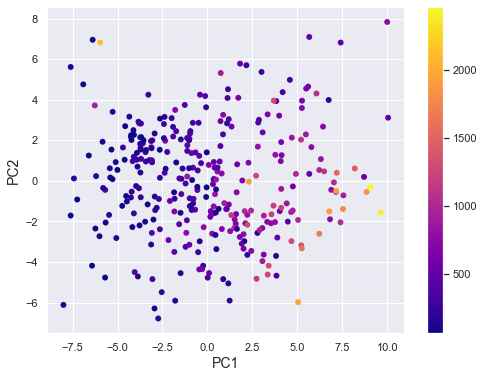

In [103]:
plt.figure(figsize=(8, 6))
plt.scatter(x=pca_comps[:, 0], y=pca_comps[:, 1], s=35, c=y, cmap='plasma', edgecolors='none');
plt.xlabel("PC1", fontsize=14)
plt.ylabel("PC2", fontsize=14)
plt.colorbar();

### Dimensionality Reduction with UMAP 

- UMAP(Uniform Manifold Approximation and Projection) is a non-linear dimension reduction technique.
- The local behavior of data in higher dimensional manifolds are also manifested in the reduced low dimension.

In [104]:
# 3D plot
_umap = UMAP(n_neighbors=7, n_components=3, metric="minkowski", init='random', random_state=22)
x_umap = _umap.fit_transform(X)
umap_df = pd.DataFrame(x_umap)
y_sr = pd.Series(y, name='Salary')
tmp = pd.concat([umap_df, y_sr], axis=1)
fig = px.scatter_3d(tmp, x=0, y=1, z=2, color='Salary')
fig.update_traces(marker_size=3, )
fig.update_layout(scene=dict(
                                xaxis_title='PC1',
                                yaxis_title='PC2',
                                zaxis_title='PC3'),
                            )
fig.show()

- Much more can be done!
- Thank you!